1. Faça o download do dataset em https://tltsilveira.github.io/public/dl-25-2-dataset.zip. Utilize
!wget e !unzip para acessar os dados via Google Colab. Utilize o módulo csv para leitura dos rotulos e o módulo skimage.io para leitura das imagens. As imagens estão no diretório imagens e os respectivos rótulos
estão no arquivo rotulos.csv.

In [4]:
# Utilitário de linha de comando usado para recuperar conteúdos de servidores web. Usado aqui para baixar o dataset.
!wget https://tltsilveira.github.io/public/dl-25-2-dataset.zip

# Utilitário de linha de comando usado para desompactar arquivos .zip
!unzip dl-25-2-dataset.zip

--2025-10-26 17:46:49--  https://tltsilveira.github.io/public/dl-25-2-dataset.zip
Resolving tltsilveira.github.io (tltsilveira.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to tltsilveira.github.io (tltsilveira.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2042887 (1.9M) [application/x-zip-compressed]
Saving to: ‘dl-25-2-dataset.zip’

dl-25-2-dataset.zip 100%[===================>]   1.95M  --.-KB/s    in 0.06s   

2025-10-26 17:46:49 (32.8 MB/s) - ‘dl-25-2-dataset.zip’ saved [2042887/2042887]

Archive:  dl-25-2-dataset.zip
  inflating: rotulos.csv             
  inflating: __MACOSX/._rotulos.csv  
   creating: imagens/
  inflating: __MACOSX/._imagens      
  inflating: imagens/1680560120019_jpg.rf.8a9bb987c88860f5b71d6a2f1541a2731.jpg  
  inflating: __MACOSX/imagens/._1680560120019_jpg.rf.8a9bb987c88860f5b71d6a2f1541a2731.jpg  
  inflating: imagens/1666100667553_jpg.rf.0d49b3b94535fb2c14897faf0c462

In [39]:
import csv
import os
import numpy as np
from skimage.io import imread


# labre o arquivo rotulos.csv para leitura
with open('rotulos.csv', mode='r') as rotulos:
  reader = csv.reader(rotulos)
  # lê os pares (imagem, rótulo) do arquivo
  imagem_rotulo_map = {}
  for row in reader:
    imagem_rotulo_map[row[0]] = row[1]

# usa skimage.io para ler os arquivos de imagem
imagens_x = []
rotulos_y = []
for imagem, rotulo in imagem_rotulo_map.items():
  caminho_imagem = os.path.join('imagens', imagem)
  # converte a imagem em um array (altura, largura, canais de cor RGB)
  array_imagem = imread(caminho_imagem)
  imagens_x.append(array_imagem)
  rotulos_y.append(rotulo)

# converte os arrays para arrays numpy (TensorFlow prefere)
X = np.array(imagens_x)
Y = np.array(rotulos_y)

print(X.shape)  # vetor de arrays de imagens
print(Y.shape)  # vetor de rótulos

(957, 64, 64, 3)
(957,)


2. Trabalhe sobre o conjunto de dados, normalizando os valores dos pixels e realizando uma divisão estratificada dos dados para criar seus proprios conjuntos independentes de treino e validação (e.g., 80%/20% ou 85%/15%).

# Observações:
- **Normalização das imagens** (entradas): processo de transformar valores numéricos dos pixeis de imagem de sua faixa original (0 - 255 em imagem de 8 bits) para uma faixa menor e padronizada (isso é feito para que a convergência do modelo seja mais rápida, entre outros motivos)

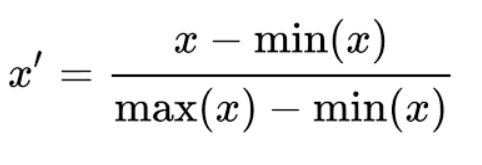

- **Codificação das saídas** (rótulos): Usa codificação **One-Hot** para codificar as classes de saídas.

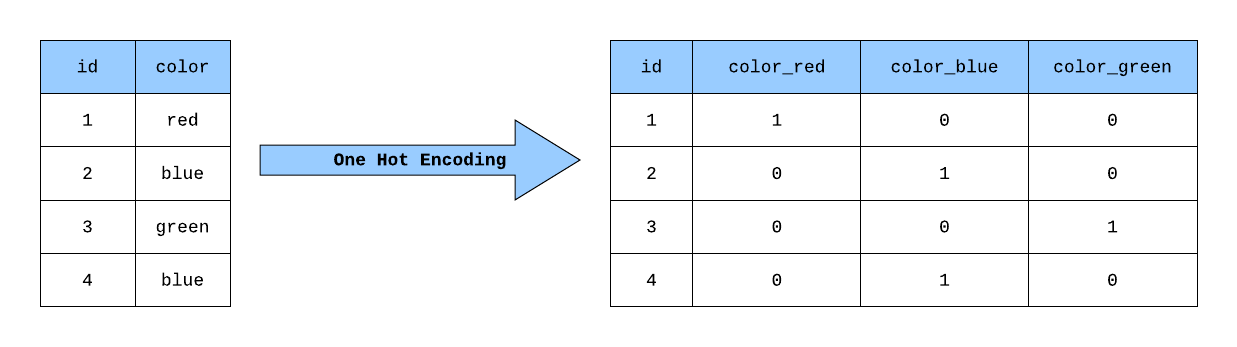

In [47]:
# normaliza as imagens usando normalização Min-Max simples
X_normalizado = X.astype('float32') / 255.0

# codifica os rótulos (Y)
classes = np.unique(Y)  # ['1', '2', '3', '4']
mapeamento = {cls: i for i, cls in enumerate(classes)}
Y_inteiros = np.array([mapeamento[rotulo] for rotulo in Y])
# codificação One-Hot
from tensorflow.keras.utils import to_categorical
Y_one_hot = to_categorical(Y_inteiros)


2. Divisão estratificada dos dados: divisão do conjunto total de amostra em subconjunsots de treino e validação

In [61]:
def divisao_estratificada(X, Y_int, proporcao=0.8, seed=42):
  """
  Divide X e Y de forma estratificada
  Sortea os índices de cada classe e sortea aleatoriamente as amostras de treino/validação dentro de cada classe, mantendo a proporção

  args:
  - X: Array de features normalizado
  - Y_int: Array de rótulos inteiros
  - proporção: Proporção para o conjunto de treino (e.g., 0.8 para 80%)

  retorno: [X_treino, x_val, y_treino_int, Y_val_int]
  """

  np.random.seed(seed)
  # Dicionário para armazenar os índices de treino e validação
  train_indices = []
  val_indices = []

  # 1. Encontra os índices para cada classe única
  classes = np.unique(Y_int)  # [0, 1, 2, 3]

  for cls in classes:
      # Encontra todos os índices que pertencem a esta classe
      indices_cls = np.where(Y_int == cls)[0]

      # Embaralha os índices da classe
      np.random.shuffle(indices_cls)

      # Calcula o ponto de corte para a proporção de treino
      split_point = int(len(indices_cls) * proporcao)

      # 2. Divide os índices da classe em Treino e Validação
      train_indices.extend(indices_cls[:split_point])
      val_indices.extend(indices_cls[split_point:])

  # 3. Embaralha os índices finais para garantir que as amostras não estejam agrupadas por classe
  np.random.shuffle(train_indices)
  np.random.shuffle(val_indices)

  # 4. Cria os subconjuntos de dados
  X_treino = X[train_indices]
  Y_treino_int = Y_int[train_indices]
  X_val = X[val_indices]
  Y_val_int = Y_int[val_indices]

  return X_treino, X_val, Y_treino_int, Y_val_int

# Usando a função
X_treino, X_val, Y_treino_int, Y_val_int = divisao_estratificada(
    X_normalizado,
    Y_inteiros,
    proporcao=0.8,  # Para divisão 80%/20%
    seed=42
)

# 4. Finalização dos Rótulos para Keras (aplicar One-Hot ao final da divisão)
# Re-aplica o One-Hot Encoding aos rótulos divididos,
# garantindo que o número de classes (num_classes) seja o mesmo (4 classes)
Y_train = to_categorical(Y_treino_int, num_classes=len(classes))
Y_val = to_categorical(Y_val_int, num_classes=len(classes))

print("\n-=-=-=-=-=-=-=- Divisão Concluída (80%/20%) -=-=-=-=-=-=-=-")
print(f"X_treino shape: {X_treino.shape} | Y_treino shape: {Y_treino_int.shape}")
print(f"X_val shape: {X_val.shape}    | Y_val shape: {Y_val_int.shape}")



-=-=-=-=-=-=-=- Divisão Concluída (80%/20%) -=-=-=-=-=-=-=-
X_treino shape: (765, 64, 64, 3) | Y_treino shape: (765,)
X_val shape: (192, 64, 64, 3)    | Y_val shape: (192,)


3. Projete e implemente uma arquitetura de uma CNN para endereçar o problema. Lembre-se que o problema mapeia imagens 64×64×3 para quatro classes. O modelo final nao deve ultrapassar 5.000.000 de parâmetros.

# Lembrando: Propósitos das camadas em uma CNN e TensorFlow/Keras

<table>
  <tr>
    <th>Tipo de camada</th>
    <th>Nome comum (Keras)</th>
    <th>Função no Processamento da Imagem</th>
  </tr>
  <tr>
    <td>Convolucional</td>
    <td>Conv2D</td>
    <td>
      Extração de Features. Aplica filtros (kernels) à entrada para detectar padrões locais (bordas, texturas, cantos). Cria mapas de ativação (feature maps).
    </td>
  </tr>
  <tr>
    <td>Agrupamento</td>
    <td>MaxPool2D</td>
    <td>
      Redução Dimensional e Invariância. Reduz a altura e largura dos mapas de feature (mantendo apenas o valor máximo em uma janela). Isso torna o modelo menos sensível a pequenas variações (translação) na imagem e reduz a carga computacional.
    </td>
  </tr>
  <tr>
    <td>Achatamento</td>
    <td>Flatten</td>
    <td>
      Transição. Converte o tensor 3D final (altura, largura, canais) do bloco convolucional em um vetor 1D, preparando-o para as camadas densas.
    </td>
  </tr>
  <tr>
    <td>Densa</td>
    <td>Dense</td>
    <td>
      Classificação. As camadas finais, onde a rede aprende a mapear as features de alto nível extraídas (pelo <b>Conv2D</b>) para as probabilidades finais de classe.
    </td>
  </tr>
  <tr>
    <td>Saída</td>
    <td>Dense</td>
    <td>
      Probabilidade. Camada <b>Dense</b> com N neurônios (nesse caso 4) e ativação <b>softmax</b>, que fornece a distribuição de probabilidade sobre as classes.
    </td>
  </tr>
</table>

# Motivação da arquitetura:
A arquitetura abaixo foi projetada com base no princípio clássico de hierarquia de features. O objetivo é transofrmar a imagem de entrada (64x64x3) em "features" de alto nível, as quais são mapeadas para as quatros classes de componentes pirolisados de smartphones.

A rede começa com 32 filtros e aumenta gradativamente sua profundidade para 256 filtros. A ideia é que essa progressão permita que as primeiras camadas se concentrem em extrair padrões básicos das imagens (e.g., bordas e texturas), enquanto as camadas mais profundas combinam essas features extraídas para identificar detalhes mais finos e a disposição desses detalhes nos componentes.

Cada bloco convolucional também é imediatamente seguido por uma camada de pooling. Além de fazer parte das melhores práticas de projeto de CNNs (reduzir carga computacional), a inclusão das camadas de pooling deve tornar a rede mais invariânte a pequenas translações de features, focando mais em sua presença e não em sua localização exata na imagem.

Finalmente, o tensor de features 3D (4 x 4 x 256) final é achatado para um vetor 1D, o qual é inserido em um classificador denso. Esta parte da rede é responsável pelo mapeamento das features abstratas extraídas para a probabilidade de cada uma das quatro classes. Ademais, uma camada de Dropout foi incluida para evitar que o classificador memorize o conjunto de treinamento (overfitting).



In [63]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, Input


#Definição do modelo
model = models.Sequential([
    Input(shape = (64, 64, 3)),                                    # dimensões da entrada (imagem 64x64 com 3 canais de cor RGB)
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),  # primeira camada convolucional. 32 kernels 3x3 com função de atrivação ReLU e padding 'same' para preservar a dimensão espacial da entrada
    layers.MaxPooling2D((2, 2)),                                   # primeira camada de pooling, com um pool size de (2, 2), o qual reduz a altura e largura da imagem pela metada (32x32)
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),  # 64 filtros
    layers.MaxPooling2D((2, 2)),                                   # imagem 16x16
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'), # 128 filtros
    layers.MaxPooling2D((2, 2)),                                   # imagem 8x8
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'), # 256 filtros
    layers.MaxPooling2D((2, 2)),                                   # imagem 4x4 ainda
    layers.Flatten(),                                              # converte op tensor final em um vetor 1d para as camadas densas
    # camadas densas para classificação
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),  # Adicionado Dropout para evitar overfitting (desativa 50% dos neuronios em cada passe treinamento)
    layers.Dense(64, activation='relu'),
    # camada de saída
    layers.Dense(4, activation='softmax')])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │     1,048,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,453,956 (5.55 MB)

 Trainable params: 1,453,956 (5.55 MB)

 Non-trainable params: 0 (0.00 B)